<a href="https://colab.research.google.com/github/alimoorreza/CS195-Fall24-Notebook-4/blob/main/cs195_notebook4_mask_rcnn_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Object detection: training/fine-tuning a pre-trained detector model**



### You need to fine-tune pretrained detectors such as Faster R-CNN and Mask R-CNN. These pretrained detectors have been using on the COCO dataset and can recognize 91 objects, including `person`, `dog`, and `cat`.
  * [Microsoft COCO (Common Object in COntext)](https://cocodataset.org/#explore)

### Your goal for this assignment is to fine-tune two pretrained models using our own UWSDet1 dataset. This dataset_, created by Drake University and Indiana University,_ contains images of various underwater animals. Our aim is to train the model to improve its ability to detect certain underwater animals.
  * __`Dolphin`__
  * __`Seal`__
  * __`Shark`__
  * __`Whale`__

###__UWSDet1 dataset__ link for fine-tuning Faster R-CNN and Mask R-CNN:
- [https://analytics.drake.edu/~reza/teaching/cs195_fall24/datasets/UWSDetv1.zip](https://analytics.drake.edu/~reza/teaching/cs195_fall24/datasets/UWSDetv1.zip)
- I have uploaded the dataset on Blackboard as well; you could download it from there as well.
- Alternately, please execute the following lines or manually download this dataset and upload it to your Google Drive:
  - !wget https://analytics.drake.edu/~reza/teaching/cs195_fall24/datasets/UWSDetv1.zip
  - !unzip UWSDetv1.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%shell
if [ -d "cs195_fall24_detection" ]; then rm -rf cs195_fall24_detection; fi
git clone https://github.com/alimoorreza/cs195_fall24_detection.git

cp cs195_fall24_detection/utils.py ./
cp cs195_fall24_detection/transforms.py ./
cp cs195_fall24_detection/coco_eval.py ./
cp cs195_fall24_detection/engine.py ./
cp cs195_fall24_detection/coco_utils.py ./


if [ -d "pycocotools" ]; then rm -rf pycocotools; fi
mkdir pycocotools
cp cs195_fall24_detection/coco.py pycocotools/coco.py
cp cs195_fall24_detection/cocoeval.py pycocotools/cocoeval.py
cp cs195_fall24_detection/mask.py pycocotools/mask.py


Cloning into 'cs195_fall24_detection'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 30 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 33.18 KiB | 11.06 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
%%shell
pip install cython

In [ ]:
import torch
print(torch.__version__)

2.5.0+cu121


In [ ]:
%%shell
#pip uninstall -y torch
pip install torch==1.11.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
pip install torchvision==0.12.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.0+cu121
    Uninstalling torch-2.5.0+cu121:
      Successfully uninstalled torch-2.5.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.0+cu121 requires torch==2.5.0, but you have torch 1.11.0+cu102 which is incompatible.
torchvision 0.20.0+cu121 requires torch==2.5.0, but you have torch 1.11.0+cu102 which is incompatible.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 86.5 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.0+cu121
    Uninstalling torchvision-0.20.0+cu121:
      Successfull

##__Super important: restart your runtime by Runtime-->Restart session__
###Otherwise, the newly installed Torch version won't be loaded into your Colab. Colab sometimes tries to load the preinstalled version of Torch from cache memory (I know it's annoying, but sorry, you may have to do this)!

In [ ]:
import torch
print(torch.__version__)

1.11.0+cu102


boundding boxes: 
[[139, 71, 543, 246]]


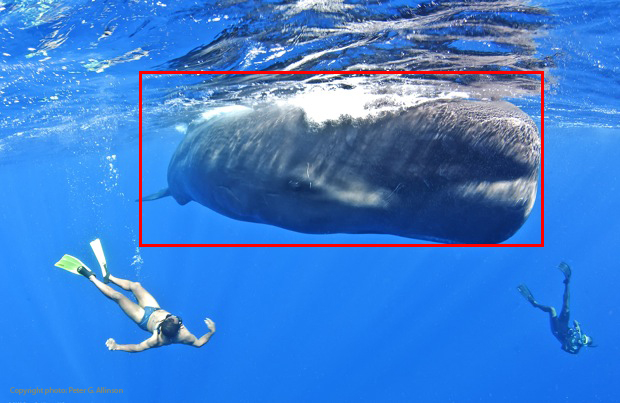

In [ ]:
# a sample visualization of bound-boxes associated with the objects (pedestrian)

import numpy as np
from PIL import Image, ImageDraw
root  = '/content/drive/MyDrive/cs195_fall24/detection/'

image_name = 'uw_animal_0095.png'
mask = Image.open(root + '/UWSDetv1/AnimMasks/' + image_name)
mask = np.array(mask)

# instances are encoded as different colors
obj_ids = np.unique(mask)
# first id is the background, so remove it
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set
# of binary masks
masks = mask == obj_ids[:, None, None]

# get bounding box coordinates for each mask
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])

print(f"boundding boxes: \n{boxes}")

# draw the bounding boxes using PIL.ImageDraw, as we did in our in-class activity #1
rgb_image = Image.open(root + '/UWSDetv1/PNGImages/' + image_name)
draw = ImageDraw.Draw(rgb_image)

# draw rectangular bouding boxes on the image
for box in boxes:
    draw.rectangle(box, outline="red", width=3)

# show the image
rgb_image


In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class AnimalDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "AnimMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path    = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path   = os.path.join(self.root, "AnimMasks", self.masks[idx])
        img         = Image.open(img_path).convert("RGB")
        mask        = Image.open(mask_path) # note that we haven't converted the mask to RGB because each color corresponds to a different instance with 0 being background



        mask        = np.array(mask)
        obj_ids     = np.unique(mask) # instances are encoded as different colors
        obj_ids     = obj_ids[1:]     # first id is the background, so remove it

        # split the color-encoded mask into a set of binary masks
        masks       = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs    = len(obj_ids)
        boxes       = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes       = torch.as_tensor(boxes, dtype=torch.float32)
        labels      = torch.ones((num_objs,), dtype=torch.int64) # there is only one class
        masks       = torch.as_tensor(masks, dtype=torch.uint8)

        image_id    = torch.tensor([idx])
        area        = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd     = torch.zeros((num_objs,), dtype=torch.int64) # suppose all instances are not crowd

        target              = {}
        target["boxes"]     = boxes
        target["labels"]    = labels
        target["masks"]     = masks
        target["image_id"]  = image_id
        target["area"]      = area
        target["iscrowd"]   = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
# use our dataset and defined transformations





#MaskRCNN Trainning and Inference
- [Mask RCNN PyTorch Reference](https://pytorch.org/vision/stable/_modules/torchvision/models/detection/mask_rcnn.html)

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.detection import maskrcnn_resnet50_fpn        # import the pretrained model
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor  # you need to adjust the total number of output predictors (eg, i) pedestrian ii) backbround), as they might differ from those in pretrained dataset MS COCO which had 91 classes
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

class MaskRCNN(nn.Module):

  def __init__(self, num_classes):
    super(MaskRCNN, self).__init__()

    self.model = maskrcnn_resnet50_fpn(pretrained=True)


    in_features = self.model.roi_heads.box_predictor.cls_score.in_features              # get the number of input features for the classifier

    self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)    # replace the pre-trained predictor head with a new one (both FastRCNN and FasterRCNN use the same predictor)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels            # get the number of input features for the classifier
    hidden_layer = 256
    self.model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,           # replace the pre-trained predictor head with a new one (MaskRCNN head)
                                                       hidden_layer,
                                                       num_classes)
  def forward(self, x, target=None):
    output = self.model(x, target)
    return output




#**Task#2.1 (2 points)**
> ### **Fine-tune the pretrained Mask R-CNN model using UWSDetv1 dataset**


>> Complete the fine-tuning step for Mask R-CNN. **(1 point)**

>> How are the loss values changing during each epoch? Are they decreasing or increasing? Write down the loss values for all 10 epochs. **(0.5 point)**

>> How well is the model performing on the test split? The evaluation metrics are precision and recall (the higher, the better). Are these numbers improving or decreasing? **(0.5 point)**

In [ ]:
# TRAINIING


#**Task#2.2 (3 points)**
> ### **Inference using the fine-tuned Mask R-CNN model on UWSDetv1 test split.**

In [ ]:
# TESTING AND VISUALIZATION



#**Write down your observations**:

>> Out of 10 test samples, in how many images were objects correctly identified without adjusting the threshold value from 0.5? You can copy the code snippet above into 10 separate cells to display your results explicitly. **(2 point)**


>> Out of 10 test samples, in how many images were objects completely missed? Additionally, note if any objects were missed due to occlusion or other challenges. **(1 point)**

